In [78]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Loading data

In [79]:
DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_speed_daily,wind_gust_max_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro
time,,,,,,,,,,,,,,,,
2024-12-27,4.0,6.0,5.250000,2.016421,6.6,7.4,6.941667,97.250000,223.583333,1.966667,6.0,0.0,0.0,131.0,12.0,NaN
2024-12-28,3.3,5.1,4.116667,1.946083,6.1,6.9,6.445833,97.666667,217.708333,3.050000,7.7,0.0,0.0,188.0,25.0,NaN
2024-12-29,4.5,8.4,7.133333,1.524006,6.1,7.4,6.812500,91.958333,231.291667,6.154167,15.4,0.1,0.0,210.0,26.0,NaN
2024-12-30,7.7,8.9,8.179167,2.204877,7.1,7.9,7.466667,91.041667,236.416667,8.741667,16.7,2.9,0.0,87.0,0.0,NaN
2024-12-31,7.9,8.6,8.300000,1.909754,7.5,7.8,7.600000,85.000000,261.000000,9.400000,16.4,0.0,0.0,0.0,0.0,NaN


In [80]:
# Check for missing values
df.isnull().sum()

temp_min_daily               0
temp_max_daily               0
temp_mean_daily              0
temp_grass_mean_daily        0
temp_soil_min_daily          0
temp_soil_max_daily          0
temp_soil_mean_daily         0
humidity_daily               0
wind_direction_daily         0
wind_speed_daily             0
wind_gust_max_daily          0
precip_total_daily           0
precip_duration_daily        0
radiation_global_daily       0
sunshine_duration_daily      0
KarupBro                   366
dtype: int64

In [81]:
# Forward fill and check again
df = df.iloc[:-366]
df.isnull().sum()

temp_min_daily             0
temp_max_daily             0
temp_mean_daily            0
temp_grass_mean_daily      0
temp_soil_min_daily        0
temp_soil_max_daily        0
temp_soil_mean_daily       0
humidity_daily             0
wind_direction_daily       0
wind_speed_daily           0
wind_gust_max_daily        0
precip_total_daily         0
precip_duration_daily      0
radiation_global_daily     0
sunshine_duration_daily    0
KarupBro                   0
dtype: int64

## Filtering data to simple model

In [82]:
df_simple = df[["temp_mean_daily", "precip_total_daily", "KarupBro"]]
df_simple.head()

,temp_mean_daily,precip_total_daily,KarupBro
time,,,
2002-01-01,1.250000,2.2,1829.75
2002-01-02,-0.837500,0.0,7279.46
2002-01-03,-5.166667,0.0,5261.85
2002-01-04,-6.025000,0.0,2951.97
2002-01-05,-3.466667,0.1,1868.53


<Axes: xlabel='time'>

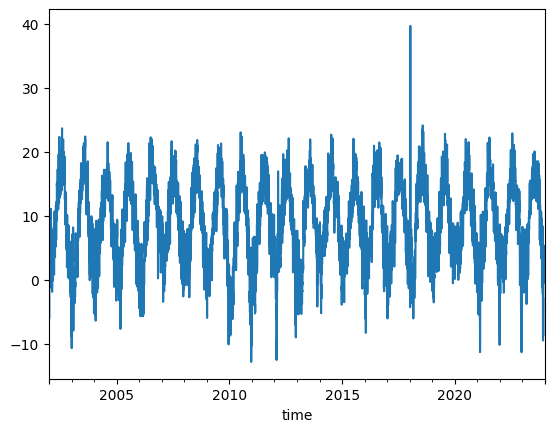

In [83]:
temp = df['temp_mean_daily']
temp.plot()

In [84]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

<Axes: xlabel='time'>

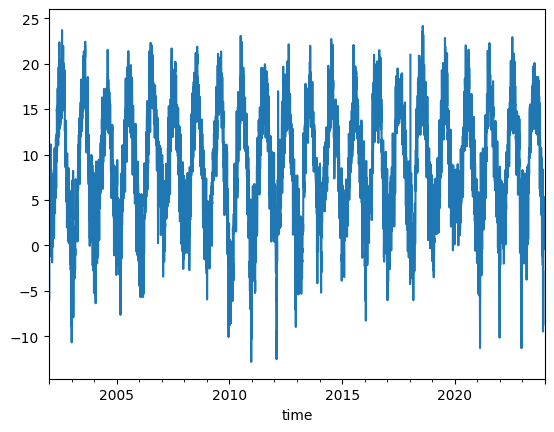

In [85]:
temp.plot()

<Axes: xlabel='time'>

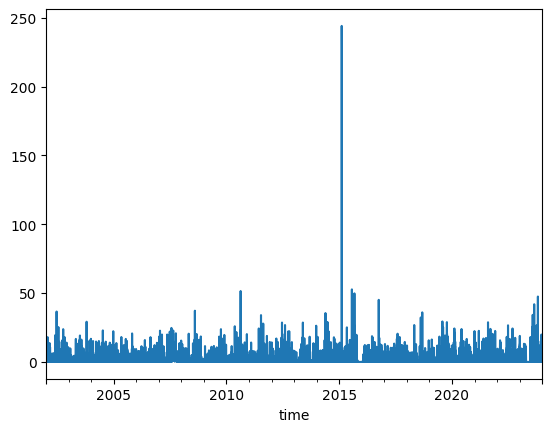

In [86]:
rain = df['precip_total_daily']
rain.plot()

In [87]:
import numpy as np

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

<Axes: xlabel='time'>

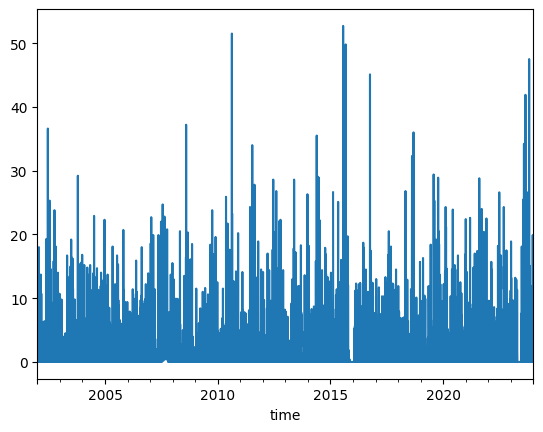

In [88]:
rain.plot()

<Axes: xlabel='time'>

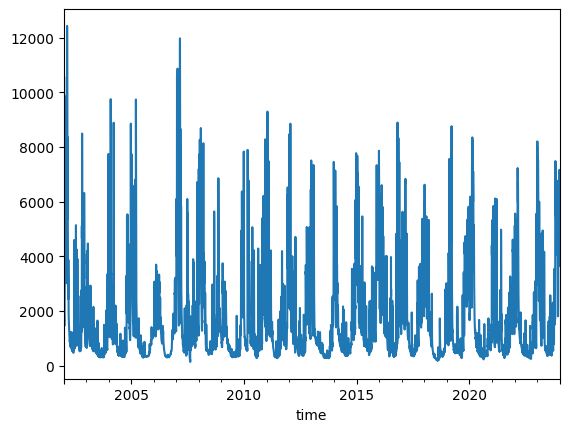

In [89]:
inflow = df['KarupBro']
inflow.plot()

In [90]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [91]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(inflow, WINDOW_SIZE)
X1.shape, y1.shape

((8030, 5, 1), (8030,))

In [92]:
X_train1, y_train1 = X1[:6000], y1[:6000]
X_val1, y_val1 = X1[6000:7000], y1[6000:7000]
X_test1, y_test1 = X1[7000:], y1[7000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((6000, 5, 1), (6000,), (1000, 5, 1), (1000,), (1030, 5, 1), (1030,))

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [95]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])

Epoch 1/50
173/188 [==========================>...] - ETA: 0s - loss: 5402759.0000 - root_mean_squared_error: 2324.3835INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 3s 12ms/step - loss: 5446029.5000 - root_mean_squared_error: 2333.6729 - val_loss: 5458243.0000 - val_root_mean_squared_error: 2336.2883
Epoch 2/50
184/188 [============================>.] - ETA: 0s - loss: 5328332.5000 - root_mean_squared_error: 2308.3181INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5324883.0000 - root_mean_squared_error: 2307.5708 - val_loss: 5274558.5000 - val_root_mean_squared_error: 2296.6406
Epoch 3/50
186/188 [============================>.] - ETA: 0s - loss: 5073355.5000 - root_mean_squared_error: 2252.4111INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 5067589.0000 - root_mean_squared_error: 2251.1306 - val_loss: 4987762.5000 - val_root_mean_squared_error: 2233.3298
Epoch 4/50
168/188 [=========================>....] - ETA: 0s - loss: 4660593.0000 - root_mean_squared_error: 2158.8406INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 8ms/step - loss: 4721178.5000 - root_mean_squared_error: 2172.8274 - val_loss: 4631880.5000 - val_root_mean_squared_error: 2152.1804
Epoch 5/50
167/188 [=========================>....] - ETA: 0s - loss: 4234981.0000 - root_mean_squared_error: 2057.9070INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 4338480.0000 - root_mean_squared_error: 2082.9019 - val_loss: 4280429.0000 - val_root_mean_squared_error: 2068.9197
Epoch 6/50
186/188 [============================>.] - ETA: 0s - loss: 3946423.7500 - root_mean_squared_error: 1986.5608INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 12ms/step - loss: 3970566.7500 - root_mean_squared_error: 1992.6281 - val_loss: 3949571.2500 - val_root_mean_squared_error: 1987.3528
Epoch 7/50
186/188 [============================>.] - ETA: 0s - loss: 3622548.2500 - root_mean_squared_error: 1903.2993INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 3618493.7500 - root_mean_squared_error: 1902.2339 - val_loss: 3614356.0000 - val_root_mean_squared_error: 1901.1460
Epoch 8/50
177/188 [===========================>..] - ETA: 0s - loss: 3318612.5000 - root_mean_squared_error: 1821.7059INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 3289724.2500 - root_mean_squared_error: 1813.7596 - val_loss: 3318927.0000 - val_root_mean_squared_error: 1821.7922
Epoch 9/50
178/188 [===========================>..] - ETA: 0s - loss: 3048291.5000 - root_mean_squared_error: 1745.9357INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 3005759.2500 - root_mean_squared_error: 1733.7125 - val_loss: 3064563.7500 - val_root_mean_squared_error: 1750.5896
Epoch 10/50
159/188 [========================>.....] - ETA: 0s - loss: 2736123.0000 - root_mean_squared_error: 1654.1230INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 2781789.7500 - root_mean_squared_error: 1667.8699 - val_loss: 2852149.5000 - val_root_mean_squared_error: 1688.8308
Epoch 11/50
178/188 [===========================>..] - ETA: 0s - loss: 2573413.2500 - root_mean_squared_error: 1604.1862INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 2573577.2500 - root_mean_squared_error: 1604.2373 - val_loss: 2634772.5000 - val_root_mean_squared_error: 1623.1982
Epoch 12/50
165/188 [=========================>....] - ETA: 0s - loss: 2421348.5000 - root_mean_squared_error: 1556.0682INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 11ms/step - loss: 2395830.5000 - root_mean_squared_error: 1547.8470 - val_loss: 2518301.0000 - val_root_mean_squared_error: 1586.9155
Epoch 13/50
177/188 [===========================>..] - ETA: 0s - loss: 2258679.7500 - root_mean_squared_error: 1502.8905INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 2260141.5000 - root_mean_squared_error: 1503.3767 - val_loss: 2314713.2500 - val_root_mean_squared_error: 1521.4182
Epoch 14/50
177/188 [===========================>..] - ETA: 0s - loss: 2043989.8750 - root_mean_squared_error: 1429.6818INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 2072201.2500 - root_mean_squared_error: 1439.5143 - val_loss: 2110849.2500 - val_root_mean_squared_error: 1452.8762
Epoch 15/50
163/188 [=========================>....] - ETA: 0s - loss: 1933320.0000 - root_mean_squared_error: 1390.4387INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 1919528.7500 - root_mean_squared_error: 1385.4706 - val_loss: 1938848.5000 - val_root_mean_squared_error: 1392.4254
Epoch 16/50
161/188 [========================>.....] - ETA: 0s - loss: 1744435.6250 - root_mean_squared_error: 1320.7709INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 1754342.6250 - root_mean_squared_error: 1324.5160 - val_loss: 1761941.5000 - val_root_mean_squared_error: 1327.3815
Epoch 17/50
185/188 [============================>.] - ETA: 0s - loss: 1596520.6250 - root_mean_squared_error: 1263.5349INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 9ms/step - loss: 1601819.5000 - root_mean_squared_error: 1265.6301 - val_loss: 1578917.7500 - val_root_mean_squared_error: 1256.5499
Epoch 18/50
173/188 [==========================>...] - ETA: 0s - loss: 1477513.1250 - root_mean_squared_error: 1215.5300INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 1480366.6250 - root_mean_squared_error: 1216.7031 - val_loss: 1430045.6250 - val_root_mean_squared_error: 1195.8451
Epoch 19/50
179/188 [===========================>..] - ETA: 0s - loss: 1357982.8750 - root_mean_squared_error: 1165.3252INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 1347985.8750 - root_mean_squared_error: 1161.0280 - val_loss: 1286071.3750 - val_root_mean_squared_error: 1134.0509
Epoch 20/50
166/188 [=========================>....] - ETA: 0s - loss: 1267054.6250 - root_mean_squared_error: 1125.6353INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 1235263.3750 - root_mean_squared_error: 1111.4241 - val_loss: 1186471.2500 - val_root_mean_squared_error: 1089.2526
Epoch 21/50
181/188 [===========================>..] - ETA: 0s - loss: 1114915.7500 - root_mean_squared_error: 1055.8958INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 1135853.3750 - root_mean_squared_error: 1065.7642 - val_loss: 1068059.6250 - val_root_mean_squared_error: 1033.4697
Epoch 22/50
178/188 [===========================>..] - ETA: 0s - loss: 1039579.0625 - root_mean_squared_error: 1019.5975INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 1053380.6250 - root_mean_squared_error: 1026.3434 - val_loss: 973807.8750 - val_root_mean_squared_error: 986.8170
Epoch 23/50
176/188 [===========================>..] - ETA: 0s - loss: 996875.2500 - root_mean_squared_error: 998.4364  INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 9ms/step - loss: 977126.5000 - root_mean_squared_error: 988.4971 - val_loss: 867678.6250 - val_root_mean_squared_error: 931.4927
Epoch 24/50
188/188 [==============================] - 0s 2ms/step - loss: 967577.6875 - root_mean_squared_error: 983.6553 - val_loss: 888735.8125 - val_root_mean_squared_error: 942.7278
Epoch 25/50
176/188 [===========================>..] - ETA: 0s - loss: 936303.0000 - root_mean_squared_error: 967.6275INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 917317.4375 - root_mean_squared_error: 957.7669 - val_loss: 823585.8750 - val_root_mean_squared_error: 907.5163
Epoch 26/50
175/188 [==========================>...] - ETA: 0s - loss: 887881.6875 - root_mean_squared_error: 942.2747INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 878646.0000 - root_mean_squared_error: 937.3612 - val_loss: 783488.8125 - val_root_mean_squared_error: 885.1490
Epoch 27/50
163/188 [=========================>....] - ETA: 0s - loss: 873932.3750 - root_mean_squared_error: 934.8435INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 848728.5000 - root_mean_squared_error: 921.2646 - val_loss: 699700.3750 - val_root_mean_squared_error: 836.4810
Epoch 28/50
167/188 [=========================>....] - ETA: 0s - loss: 786628.6250 - root_mean_squared_error: 886.9208INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 784015.8750 - root_mean_squared_error: 885.4467 - val_loss: 665813.6875 - val_root_mean_squared_error: 815.9741
Epoch 29/50
187/188 [============================>.] - ETA: 0s - loss: 760680.5625 - root_mean_squared_error: 872.1700INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 9ms/step - loss: 759001.0625 - root_mean_squared_error: 871.2067 - val_loss: 629427.7500 - val_root_mean_squared_error: 793.3648
Epoch 30/50
188/188 [==============================] - 0s 2ms/step - loss: 726786.8750 - root_mean_squared_error: 852.5179 - val_loss: 668318.4375 - val_root_mean_squared_error: 817.5074
Epoch 31/50
178/188 [===========================>..] - ETA: 0s - loss: 744491.2500 - root_mean_squared_error: 862.8391INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 751036.2500 - root_mean_squared_error: 866.6235 - val_loss: 605991.2500 - val_root_mean_squared_error: 778.4544
Epoch 32/50
179/188 [===========================>..] - ETA: 0s - loss: 678090.5625 - root_mean_squared_error: 823.4625INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 694745.8125 - root_mean_squared_error: 833.5142 - val_loss: 580063.1250 - val_root_mean_squared_error: 761.6188
Epoch 33/50
179/188 [===========================>..] - ETA: 0s - loss: 697065.8125 - root_mean_squared_error: 834.9047INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 691103.9375 - root_mean_squared_error: 831.3266 - val_loss: 541760.8125 - val_root_mean_squared_error: 736.0440
Epoch 34/50
188/188 [==============================] - 0s 2ms/step - loss: 667557.6875 - root_mean_squared_error: 817.0421 - val_loss: 567739.5000 - val_root_mean_squared_error: 753.4849
Epoch 35/50
182/188 [============================>.] - ETA: 0s - loss: 662229.8125 - root_mean_squared_error: 813.7750INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 649288.6875 - root_mean_squared_error: 805.7845 - val_loss: 528907.3750 - val_root_mean_squared_error: 727.2602
Epoch 36/50
188/188 [==============================] - 0s 2ms/step - loss: 646755.5000 - root_mean_squared_error: 804.2111 - val_loss: 544479.6250 - val_root_mean_squared_error: 737.8886
Epoch 37/50
188/188 [==============================] - 0s 2ms/step - loss: 629905.2500 - root_mean_squared_error: 793.6657 - val_loss: 557945.6250 - val_root_mean_squared_error: 746.9576
Epoch 38/50
181/188 [===========================>..] - ETA: 0s - loss: 654740.1250 - root_mean_squared_error: 809.1602INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 660409.4375 - root_mean_squared_error: 812.6558 - val_loss: 474737.4688 - val_root_mean_squared_error: 689.0120
Epoch 39/50
181/188 [===========================>..] - ETA: 0s - loss: 602607.6250 - root_mean_squared_error: 776.2781INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 9ms/step - loss: 595116.6875 - root_mean_squared_error: 771.4380 - val_loss: 465485.1562 - val_root_mean_squared_error: 682.2647
Epoch 40/50
188/188 [==============================] - 0s 2ms/step - loss: 602813.3750 - root_mean_squared_error: 776.4106 - val_loss: 494826.6562 - val_root_mean_squared_error: 703.4391
Epoch 41/50
188/188 [==============================] - 0s 2ms/step - loss: 617829.4375 - root_mean_squared_error: 786.0212 - val_loss: 488609.5312 - val_root_mean_squared_error: 699.0061
Epoch 42/50
188/188 [==============================] - 0s 2ms/step - loss: 592837.0000 - root_mean_squared_error: 769.9591 - val_loss: 486957.6562 - val_root_mean_squared_error: 697.8235
Epoch 43/50
188/188 [==============================] - 0s 2ms/step - loss: 615761.9375 - root_mean_squared_error: 784.7050 - val_loss: 467453.4688 - val_root_mean_squared_error: 683.7057
Epoch 44/50
188/188 [==============================] - 0s 2ms/step - loss: 62

INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 618336.5625 - root_mean_squared_error: 786.3438 - val_loss: 455369.1875 - val_root_mean_squared_error: 674.8105
Epoch 47/50
188/188 [==============================] - 0s 2ms/step - loss: 604265.2500 - root_mean_squared_error: 777.3450 - val_loss: 485521.3438 - val_root_mean_squared_error: 696.7936
Epoch 48/50
180/188 [===========================>..] - ETA: 0s - loss: 613912.3750 - root_mean_squared_error: 783.5256INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 607684.3750 - root_mean_squared_error: 779.5411 - val_loss: 431908.3125 - val_root_mean_squared_error: 657.1973
Epoch 49/50
188/188 [==============================] - 0s 2ms/step - loss: 608525.4375 - root_mean_squared_error: 780.0804 - val_loss: 496304.9688 - val_root_mean_squared_error: 704.4891
Epoch 50/50
188/188 [==============================] - 0s 2ms/step - loss: 616221.3750 - root_mean_squared_error: 784.9977 - val_loss: 560562.9375 - val_root_mean_squared_error: 748.7075


In [96]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [97]:
from sklearn.metrics import root_mean_squared_error as rmse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, rmse(predictions, y)

33/33 [==============================] - 0s 745us/step


(      Predictions  Actuals
 0     1121.507935  1015.35
 1     1110.052734   905.19
 2      994.182617   862.98
 3      919.043335   832.00
 4      848.623474  3217.89
 ...           ...      ...
 1025  4600.983398  5197.40
 1026  4598.473633  6368.46
 1027  4601.373047  7162.01
 1028  4601.393555  6869.41
 1029  4601.391602  6335.36
 
 [1030 rows x 2 columns],
 685.4209574803795)

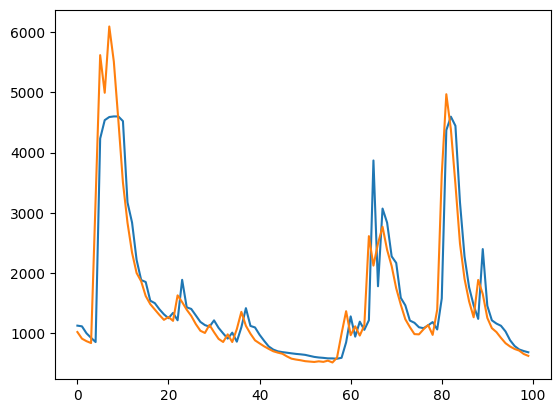

In [98]:
plot_predictions1(model1, X_test1, y_test1)

## Conv1D model

In [99]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             192       
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 2056      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2257 (8.82 KB)
Trainable params: 2257 (8.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [101]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp2])

Epoch 1/50
 84/188 [============>.................] - ETA: 0s - loss: 1425666.6250 - root_mean_squared_error: 1194.0128 INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 1s 2ms/step - loss: 954416.0625 - root_mean_squared_error: 976.9422 - val_loss: 304067.5312 - val_root_mean_squared_error: 551.4232
Epoch 2/50
111/188 [================>.............] - ETA: 0s - loss: 446009.2188 - root_mean_squared_error: 667.8392INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 405939.1250 - root_mean_squared_error: 637.1335 - val_loss: 192602.7031 - val_root_mean_squared_error: 438.8652
Epoch 3/50
114/188 [=================>............] - ETA: 0s - loss: 377179.6562 - root_mean_squared_error: 614.1495INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 342407.0938 - root_mean_squared_error: 585.1556 - val_loss: 168507.4688 - val_root_mean_squared_error: 410.4966
Epoch 4/50
188/188 [==============================] - 0s 592us/step - loss: 331736.9688 - root_mean_squared_error: 575.9661 - val_loss: 177774.9375 - val_root_mean_squared_error: 421.6337
Epoch 5/50
108/188 [================>.............] - ETA: 0s - loss: 357058.8438 - root_mean_squared_error: 597.5440INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 330957.2812 - root_mean_squared_error: 575.2889 - val_loss: 165451.4844 - val_root_mean_squared_error: 406.7573
Epoch 6/50
188/188 [==============================] - 0s 561us/step - loss: 330249.5000 - root_mean_squared_error: 574.6734 - val_loss: 184873.9531 - val_root_mean_squared_error: 429.9697
Epoch 7/50
188/188 [==============================] - 0s 578us/step - loss: 327198.2812 - root_mean_squared_error: 572.0125 - val_loss: 167855.7031 - val_root_mean_squared_error: 409.7020
Epoch 8/50
109/188 [================>.............] - ETA: 0s - loss: 316920.8438 - root_mean_squared_error: 562.9572INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 322759.6562 - root_mean_squared_error: 568.1194 - val_loss: 161506.2656 - val_root_mean_squared_error: 401.8784
Epoch 9/50
188/188 [==============================] - 0s 778us/step - loss: 329081.6250 - root_mean_squared_error: 573.6564 - val_loss: 184777.5000 - val_root_mean_squared_error: 429.8575
Epoch 10/50
188/188 [==============================] - 0s 593us/step - loss: 324707.8125 - root_mean_squared_error: 569.8314 - val_loss: 166260.9688 - val_root_mean_squared_error: 407.7511
Epoch 11/50
188/188 [==============================] - 0s 592us/step - loss: 323597.2188 - root_mean_squared_error: 568.8561 - val_loss: 162451.8125 - val_root_mean_squared_error: 403.0531
Epoch 12/50
188/188 [==============================] - 0s 577us/step - loss: 322549.4688 - root_mean_squared_error: 567.9344 - val_loss: 163857.1406 - val_root_mean_squared_error: 404.7927
Epoch 13/50
188/188 [==============================] - 0s 581us/step -

INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 321126.0938 - root_mean_squared_error: 566.6799 - val_loss: 156788.8906 - val_root_mean_squared_error: 395.9658
Epoch 18/50
188/188 [==============================] - 0s 610us/step - loss: 321230.8438 - root_mean_squared_error: 566.7723 - val_loss: 161535.1250 - val_root_mean_squared_error: 401.9143
Epoch 19/50
188/188 [==============================] - 0s 576us/step - loss: 321132.2812 - root_mean_squared_error: 566.6854 - val_loss: 164774.5312 - val_root_mean_squared_error: 405.9243
Epoch 20/50
188/188 [==============================] - 0s 585us/step - loss: 322950.8438 - root_mean_squared_error: 568.2877 - val_loss: 157809.7812 - val_root_mean_squared_error: 397.2528
Epoch 21/50
188/188 [==============================] - 0s 574us/step - loss: 319795.5625 - root_mean_squared_error: 565.5047 - val_loss: 164519.1562 - val_root_mean_squared_error: 405.6096
Epoch 22/50
188/188 [==============================] - 0s 586us/step 

INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 322060.8750 - root_mean_squared_error: 567.5041 - val_loss: 155470.5000 - val_root_mean_squared_error: 394.2975
Epoch 26/50
188/188 [==============================] - 0s 571us/step - loss: 319032.5000 - root_mean_squared_error: 564.8296 - val_loss: 159692.8750 - val_root_mean_squared_error: 399.6159
Epoch 27/50
188/188 [==============================] - 0s 594us/step - loss: 321222.9688 - root_mean_squared_error: 566.7654 - val_loss: 158442.0000 - val_root_mean_squared_error: 398.0477
Epoch 28/50
188/188 [==============================] - 0s 592us/step - loss: 326680.3438 - root_mean_squared_error: 571.5596 - val_loss: 158869.8125 - val_root_mean_squared_error: 398.5847
Epoch 29/50
188/188 [==============================] - 0s 748us/step - loss: 317352.3438 - root_mean_squared_error: 563.3403 - val_loss: 162508.8594 - val_root_mean_squared_error: 403.1239
Epoch 30/50
188/188 [==============================] - 0s 584us/step 

33/33 [==============================] - 0s 420us/step


(      Predictions  Actuals
 0     1077.790405  1015.35
 1     1079.379272   905.19
 2      881.926025   862.98
 3      912.929871   832.00
 4      857.660034  3217.89
 ...           ...      ...
 1025  5703.439453  5197.40
 1026  4994.169922  6368.46
 1027  6933.777832  7162.01
 1028  7200.994141  6869.41
 1029  6582.094727  6335.36
 
 [1030 rows x 2 columns],
 432.88671172276736)

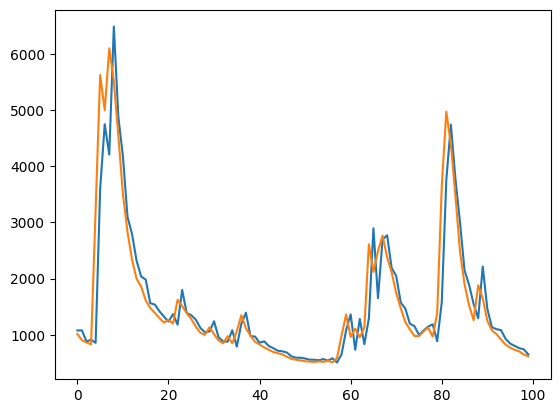

In [102]:
plot_predictions1(model2, X_test1, y_test1)

## GRU Model

In [103]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [104]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [105]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp3])

Epoch 1/50
172/188 [==========================>...] - ETA: 0s - loss: 5391792.5000 - root_mean_squared_error: 2322.0234INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 3s 11ms/step - loss: 5460755.0000 - root_mean_squared_error: 2336.8259 - val_loss: 5478110.0000 - val_root_mean_squared_error: 2340.5364
Epoch 2/50
176/188 [===========================>..] - ETA: 0s - loss: 5377147.0000 - root_mean_squared_error: 2318.8677INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 5370901.5000 - root_mean_squared_error: 2317.5205 - val_loss: 5362042.5000 - val_root_mean_squared_error: 2315.6084
Epoch 3/50
178/188 [===========================>..] - ETA: 0s - loss: 5205660.0000 - root_mean_squared_error: 2281.5916INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 5215024.0000 - root_mean_squared_error: 2283.6428 - val_loss: 5181761.5000 - val_root_mean_squared_error: 2276.3484
Epoch 4/50
158/188 [========================>.....] - ETA: 0s - loss: 5040190.5000 - root_mean_squared_error: 2245.0369INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 4999005.5000 - root_mean_squared_error: 2235.8457 - val_loss: 4953687.0000 - val_root_mean_squared_error: 2225.6880
Epoch 5/50
186/188 [============================>.] - ETA: 0s - loss: 4754819.5000 - root_mean_squared_error: 2180.5549INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 4738924.0000 - root_mean_squared_error: 2176.9070 - val_loss: 4699142.5000 - val_root_mean_squared_error: 2167.7505
Epoch 6/50
184/188 [============================>.] - ETA: 0s - loss: 4450087.5000 - root_mean_squared_error: 2109.5229INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 4459983.0000 - root_mean_squared_error: 2111.8672 - val_loss: 4434643.5000 - val_root_mean_squared_error: 2105.8594
Epoch 7/50
169/188 [=========================>....] - ETA: 0s - loss: 4244407.5000 - root_mean_squared_error: 2060.1960INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 9ms/step - loss: 4176686.7500 - root_mean_squared_error: 2043.6943 - val_loss: 4174465.5000 - val_root_mean_squared_error: 2043.1509
Epoch 8/50
175/188 [==========================>...] - ETA: 0s - loss: 3862501.0000 - root_mean_squared_error: 1965.3247INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3902647.2500 - root_mean_squared_error: 1975.5118 - val_loss: 3932233.2500 - val_root_mean_squared_error: 1982.9860
Epoch 9/50
172/188 [==========================>...] - ETA: 0s - loss: 3691640.2500 - root_mean_squared_error: 1921.3641INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3649241.0000 - root_mean_squared_error: 1910.2987 - val_loss: 3713978.5000 - val_root_mean_squared_error: 1927.1686
Epoch 10/50
166/188 [=========================>....] - ETA: 0s - loss: 3475842.2500 - root_mean_squared_error: 1864.3611INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3425406.7500 - root_mean_squared_error: 1850.7854 - val_loss: 3528357.5000 - val_root_mean_squared_error: 1878.3922
Epoch 11/50
188/188 [==============================] - ETA: 0s - loss: 3235333.7500 - root_mean_squared_error: 1798.7034INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 3235333.7500 - root_mean_squared_error: 1798.7034 - val_loss: 3376799.7500 - val_root_mean_squared_error: 1837.6071
Epoch 12/50
188/188 [==============================] - ETA: 0s - loss: 3079344.5000 - root_mean_squared_error: 1754.8062INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 3079344.5000 - root_mean_squared_error: 1754.8062 - val_loss: 3255829.2500 - val_root_mean_squared_error: 1804.3916
Epoch 13/50
168/188 [=========================>....] - ETA: 0s - loss: 2995977.2500 - root_mean_squared_error: 1730.8892INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 10ms/step - loss: 2956936.2500 - root_mean_squared_error: 1719.5745 - val_loss: 3166604.7500 - val_root_mean_squared_error: 1779.4956
Epoch 14/50
170/188 [==========================>...] - ETA: 0s - loss: 2830274.7500 - root_mean_squared_error: 1682.3420INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2865635.2500 - root_mean_squared_error: 1692.8187 - val_loss: 3104374.7500 - val_root_mean_squared_error: 1761.9236
Epoch 15/50
175/188 [==========================>...] - ETA: 0s - loss: 2832617.5000 - root_mean_squared_error: 1683.0382INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 2799928.7500 - root_mean_squared_error: 1673.2987 - val_loss: 3061985.2500 - val_root_mean_squared_error: 1749.8529
Epoch 16/50
172/188 [==========================>...] - ETA: 0s - loss: 2752245.5000 - root_mean_squared_error: 1658.9893INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2755569.2500 - root_mean_squared_error: 1659.9907 - val_loss: 3035345.7500 - val_root_mean_squared_error: 1742.2244
Epoch 17/50
177/188 [===========================>..] - ETA: 0s - loss: 2665226.7500 - root_mean_squared_error: 1632.5522INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2725147.7500 - root_mean_squared_error: 1650.8021 - val_loss: 3020390.2500 - val_root_mean_squared_error: 1737.9270
Epoch 18/50
174/188 [==========================>...] - ETA: 0s - loss: 2712926.2500 - root_mean_squared_error: 1647.0963INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2705735.0000 - root_mean_squared_error: 1644.9119 - val_loss: 3009494.2500 - val_root_mean_squared_error: 1734.7894
Epoch 19/50
173/188 [==========================>...] - ETA: 0s - loss: 2696336.2500 - root_mean_squared_error: 1642.0525INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2692338.7500 - root_mean_squared_error: 1640.8347 - val_loss: 3001159.5000 - val_root_mean_squared_error: 1732.3855
Epoch 20/50
182/188 [============================>.] - ETA: 0s - loss: 2661937.5000 - root_mean_squared_error: 1631.5446INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 10ms/step - loss: 2682316.0000 - root_mean_squared_error: 1637.7777 - val_loss: 2998799.0000 - val_root_mean_squared_error: 1731.7041
Epoch 21/50
179/188 [===========================>..] - ETA: 0s - loss: 2628695.0000 - root_mean_squared_error: 1621.3251INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2673115.7500 - root_mean_squared_error: 1634.9666 - val_loss: 2964022.5000 - val_root_mean_squared_error: 1721.6337
Epoch 22/50
171/188 [==========================>...] - ETA: 0s - loss: 2670007.5000 - root_mean_squared_error: 1634.0157INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2649242.5000 - root_mean_squared_error: 1627.6494 - val_loss: 2948354.2500 - val_root_mean_squared_error: 1717.0773
Epoch 23/50
183/188 [============================>.] - ETA: 0s - loss: 2646002.2500 - root_mean_squared_error: 1626.6537INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 2632397.7500 - root_mean_squared_error: 1622.4666 - val_loss: 2932694.0000 - val_root_mean_squared_error: 1712.5110
Epoch 24/50
174/188 [==========================>...] - ETA: 0s - loss: 2659552.2500 - root_mean_squared_error: 1630.8134INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2623003.2500 - root_mean_squared_error: 1619.5688 - val_loss: 2923083.0000 - val_root_mean_squared_error: 1709.7026
Epoch 25/50
177/188 [===========================>..] - ETA: 0s - loss: 2631539.5000 - root_mean_squared_error: 1622.2020INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2612675.0000 - root_mean_squared_error: 1616.3771 - val_loss: 2915876.5000 - val_root_mean_squared_error: 1707.5938
Epoch 26/50
169/188 [=========================>....] - ETA: 0s - loss: 2586934.2500 - root_mean_squared_error: 1608.3949INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 9ms/step - loss: 2602688.7500 - root_mean_squared_error: 1613.2850 - val_loss: 2900472.2500 - val_root_mean_squared_error: 1703.0773
Epoch 27/50
170/188 [==========================>...] - ETA: 0s - loss: 2605547.0000 - root_mean_squared_error: 1614.1707INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2594556.2500 - root_mean_squared_error: 1610.7626 - val_loss: 2893823.2500 - val_root_mean_squared_error: 1701.1241
Epoch 28/50
173/188 [==========================>...] - ETA: 0s - loss: 2624265.2500 - root_mean_squared_error: 1619.9584INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2584616.5000 - root_mean_squared_error: 1607.6742 - val_loss: 2884509.7500 - val_root_mean_squared_error: 1698.3844
Epoch 29/50
172/188 [==========================>...] - ETA: 0s - loss: 2613880.0000 - root_mean_squared_error: 1616.7499INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2577532.7500 - root_mean_squared_error: 1605.4696 - val_loss: 2874011.0000 - val_root_mean_squared_error: 1695.2908
Epoch 30/50
175/188 [==========================>...] - ETA: 0s - loss: 2557767.5000 - root_mean_squared_error: 1599.3022INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2570925.5000 - root_mean_squared_error: 1603.4106 - val_loss: 2870412.0000 - val_root_mean_squared_error: 1694.2290
Epoch 31/50
174/188 [==========================>...] - ETA: 0s - loss: 2556845.5000 - root_mean_squared_error: 1599.0139INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2561648.5000 - root_mean_squared_error: 1600.5150 - val_loss: 2855392.2500 - val_root_mean_squared_error: 1689.7906
Epoch 32/50
171/188 [==========================>...] - ETA: 0s - loss: 2572325.5000 - root_mean_squared_error: 1603.8470INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2552916.5000 - root_mean_squared_error: 1597.7849 - val_loss: 2841321.7500 - val_root_mean_squared_error: 1685.6221
Epoch 33/50
173/188 [==========================>...] - ETA: 0s - loss: 2533765.0000 - root_mean_squared_error: 1591.7804INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 10ms/step - loss: 2545386.2500 - root_mean_squared_error: 1595.4266 - val_loss: 2841204.5000 - val_root_mean_squared_error: 1685.5873
Epoch 34/50
185/188 [============================>.] - ETA: 0s - loss: 2514825.2500 - root_mean_squared_error: 1585.8201INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 2534644.5000 - root_mean_squared_error: 1592.0566 - val_loss: 2823129.2500 - val_root_mean_squared_error: 1680.2170
Epoch 35/50
188/188 [==============================] - 0s 2ms/step - loss: 2527555.2500 - root_mean_squared_error: 1589.8287 - val_loss: 2824771.7500 - val_root_mean_squared_error: 1680.7057
Epoch 36/50
175/188 [==========================>...] - ETA: 0s - loss: 2519153.2500 - root_mean_squared_error: 1587.1841INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2517384.2500 - root_mean_squared_error: 1586.6267 - val_loss: 2806537.2500 - val_root_mean_squared_error: 1675.2723
Epoch 37/50
174/188 [==========================>...] - ETA: 0s - loss: 2521062.2500 - root_mean_squared_error: 1587.7853INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2510306.7500 - root_mean_squared_error: 1584.3948 - val_loss: 2804225.7500 - val_root_mean_squared_error: 1674.5823
Epoch 38/50
176/188 [===========================>..] - ETA: 0s - loss: 2509673.7500 - root_mean_squared_error: 1584.1949INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2500847.5000 - root_mean_squared_error: 1581.4069 - val_loss: 2785246.0000 - val_root_mean_squared_error: 1668.9056
Epoch 39/50
175/188 [==========================>...] - ETA: 0s - loss: 2506593.7500 - root_mean_squared_error: 1583.2225INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 2493644.7500 - root_mean_squared_error: 1579.1278 - val_loss: 2774806.7500 - val_root_mean_squared_error: 1665.7751
Epoch 40/50
161/188 [========================>.....] - ETA: 0s - loss: 2547815.0000 - root_mean_squared_error: 1596.1876INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 9ms/step - loss: 2483544.2500 - root_mean_squared_error: 1575.9265 - val_loss: 2765707.2500 - val_root_mean_squared_error: 1663.0416
Epoch 41/50
159/188 [========================>.....] - ETA: 0s - loss: 2482947.2500 - root_mean_squared_error: 1575.7371INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 2475497.2500 - root_mean_squared_error: 1573.3713 - val_loss: 2757094.2500 - val_root_mean_squared_error: 1660.4501
Epoch 42/50
180/188 [===========================>..] - ETA: 0s - loss: 2503617.2500 - root_mean_squared_error: 1582.2823INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 2467545.5000 - root_mean_squared_error: 1570.8423 - val_loss: 2743052.5000 - val_root_mean_squared_error: 1656.2163
Epoch 43/50
176/188 [===========================>..] - ETA: 0s - loss: 2493894.0000 - root_mean_squared_error: 1579.2068INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 2456760.7500 - root_mean_squared_error: 1567.4058 - val_loss: 2731490.5000 - val_root_mean_squared_error: 1652.7222
Epoch 44/50
188/188 [==============================] - 0s 2ms/step - loss: 2446714.2500 - root_mean_squared_error: 1564.1976 - val_loss: 2731947.5000 - val_root_mean_squared_error: 1652.8604
Epoch 45/50
155/188 [=======================>......] - ETA: 0s - loss: 2462222.7500 - root_mean_squared_error: 1569.1471INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 2440955.0000 - root_mean_squared_error: 1562.3556 - val_loss: 2712519.5000 - val_root_mean_squared_error: 1646.9728
Epoch 46/50
188/188 [==============================] - 0s 2ms/step - loss: 2432440.7500 - root_mean_squared_error: 1559.6284 - val_loss: 2715338.2500 - val_root_mean_squared_error: 1647.8284
Epoch 47/50
175/188 [==========================>...] - ETA: 0s - loss: 2424994.5000 - root_mean_squared_error: 1557.2394INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2421984.0000 - root_mean_squared_error: 1556.2725 - val_loss: 2688062.2500 - val_root_mean_squared_error: 1639.5311
Epoch 48/50
167/188 [=========================>....] - ETA: 0s - loss: 2433479.0000 - root_mean_squared_error: 1559.9612INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2410544.5000 - root_mean_squared_error: 1552.5928 - val_loss: 2677270.0000 - val_root_mean_squared_error: 1636.2366
Epoch 49/50
184/188 [============================>.] - ETA: 0s - loss: 2401765.5000 - root_mean_squared_error: 1549.7631INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 10ms/step - loss: 2399887.2500 - root_mean_squared_error: 1549.1570 - val_loss: 2663981.0000 - val_root_mean_squared_error: 1632.1707
Epoch 50/50
188/188 [==============================] - 0s 2ms/step - loss: 2391498.7500 - root_mean_squared_error: 1546.4471 - val_loss: 2674994.7500 - val_root_mean_squared_error: 1635.5411


33/33 [==============================] - 0s 701us/step


(      Predictions  Actuals
 0     1844.759521  1015.35
 1     1823.078613   905.19
 2     1722.167358   862.98
 3     1581.804199   832.00
 4     1547.446411  3217.89
 ...           ...      ...
 1025  1930.170166  5197.40
 1026  1930.170166  6368.46
 1027  1930.170166  7162.01
 1028  1930.170166  6869.41
 1029  1930.170166  6335.36
 
 [1030 rows x 2 columns],
 1667.473590938374)

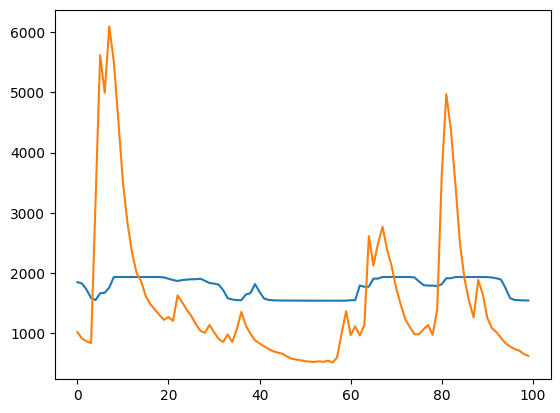

In [106]:
plot_predictions1(model3, X_test1, y_test1)

## Multi-variable

In [107]:
inflow_df = pd.DataFrame({'Inflow':inflow})
inflow_df['Seconds'] = inflow_df.index.map(pd.Timestamp.timestamp)
inflow_df

,Inflow,Seconds
time,,
2002-01-01,1829.75,1.009843e+09
2002-01-02,7279.46,1.009930e+09
2002-01-03,5261.85,1.010016e+09
2002-01-04,2951.97,1.010102e+09
2002-01-05,1868.53,1.010189e+09
...,...,...
2023-12-27,5197.40,1.703635e+09
2023-12-28,6368.46,1.703722e+09
2023-12-29,7162.01,1.703808e+09


In [108]:
day = 24*60*60
year = (365.2425)*day

inflow_df['Rain'] = df['precip_total_daily']
inflow_df['Temp'] = df['temp_mean_daily']
inflow_df['Year sin'] = np.sin(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df['Year cos'] = np.cos(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df = inflow_df.drop('Seconds', axis=1)
inflow_df

,Inflow,Rain,Temp,Year sin,Year cos
time,,,,,
2002-01-01,1829.75,2.2,1.250000,0.004129,0.999991
2002-01-02,7279.46,0.0,-0.837500,0.021330,0.999772
2002-01-03,5261.85,0.0,-5.166667,0.038525,0.999258
2002-01-04,2951.97,0.0,-6.025000,0.055708,0.998447
2002-01-05,1868.53,0.1,-3.466667,0.072875,0.997341
...,...,...,...,...,...
2023-12-27,5197.40,0.0,0.471667,-0.087536,0.996161
2023-12-28,6368.46,0.0,0.255556,-0.070387,0.997520
2023-12-29,7162.01,0.0,0.039444,-0.053217,0.998583


In [109]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [110]:
X2, y2 = df_to_X_y2(inflow_df)
X2.shape, y2.shape

((8029, 6, 5), (8029,))

In [111]:
X2_train, y2_train = X2[:6000], y2[:6000]
X2_val, y2_val = X2[6000:7000], y2[6000:7000]
X2_test, y2_test = X2[7000:], y2[7000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((6000, 6, 5), (6000,), (1000, 6, 5), (1000,), (1029, 6, 5), (1029,))

### Preprocessing

In [113]:
inflow_training_mean = np.mean(X2_train[:, :, 0])
inflow_training_std = np.std(X2_train[:, :, 0])

rain_training_mean = np.mean(X2_train[:, :, 1])
rain_training_std = np.std(X2_train[:, :, 1])

temp_training_mean = np.mean(X2_train[:, :, 2])
temp_training_std = np.std(X2_train[:, :, 2])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - inflow_training_mean) / inflow_training_std 
  X[:, :, 1] = (X[:, :, 1] - rain_training_mean) / rain_training_std
  X[:, :, 2] = (X[:, :, 2] - temp_training_mean) / temp_training_std 
  return X

def preprocess_output(y):
  y[0] = (y[0] - inflow_training_mean) / inflow_training_std
  return y

preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)
preprocess_output(y2_train)
preprocess_output(y2_val)
preprocess_output(y2_test)

array([ 905.19,  862.98,  832.  , ..., 7162.01, 6869.41, 6335.36])

In [122]:
X2_test.shape , y2_test.shape

((1029, 6, 5), (1029,))

In [114]:
model4 = Sequential()
model4.add(InputLayer((6, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17920     
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18449 (72.07 KB)
Trainable params: 18449 (72.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [116]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp4])

Epoch 1/50
173/188 [==========================>...] - ETA: 0s - loss: 5371540.0000 - root_mean_squared_error: 2317.6582INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 9ms/step - loss: 5403252.5000 - root_mean_squared_error: 2324.4897 - val_loss: 5361176.5000 - val_root_mean_squared_error: 2315.4214
Epoch 2/50
180/188 [===========================>..] - ETA: 0s - loss: 5195640.0000 - root_mean_squared_error: 2279.3948INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 5180385.5000 - root_mean_squared_error: 2276.0461 - val_loss: 5112231.0000 - val_root_mean_squared_error: 2261.0244
Epoch 3/50
162/188 [========================>.....] - ETA: 0s - loss: 4831168.0000 - root_mean_squared_error: 2197.9917INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 4873920.0000 - root_mean_squared_error: 2207.6956 - val_loss: 4788351.0000 - val_root_mean_squared_error: 2188.2302
Epoch 4/50
188/188 [==============================] - ETA: 0s - loss: 4502107.5000 - root_mean_squared_error: 2121.8171INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 4502107.5000 - root_mean_squared_error: 2121.8171 - val_loss: 4423637.0000 - val_root_mean_squared_error: 2103.2444
Epoch 5/50
165/188 [=========================>....] - ETA: 0s - loss: 4131676.0000 - root_mean_squared_error: 2032.6525INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 10ms/step - loss: 4108326.0000 - root_mean_squared_error: 2026.9006 - val_loss: 4063280.2500 - val_root_mean_squared_error: 2015.7579
Epoch 6/50
165/188 [=========================>....] - ETA: 0s - loss: 3839127.2500 - root_mean_squared_error: 1959.3691INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 3734689.7500 - root_mean_squared_error: 1932.5345 - val_loss: 3740220.0000 - val_root_mean_squared_error: 1933.9648
Epoch 7/50
185/188 [============================>.] - ETA: 0s - loss: 3397833.7500 - root_mean_squared_error: 1843.3214INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 3402421.0000 - root_mean_squared_error: 1844.5653 - val_loss: 3385189.5000 - val_root_mean_squared_error: 1839.8884
Epoch 8/50
186/188 [============================>.] - ETA: 0s - loss: 3047369.2500 - root_mean_squared_error: 1745.6716INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 3036840.5000 - root_mean_squared_error: 1742.6533 - val_loss: 3020242.5000 - val_root_mean_squared_error: 1737.8845
Epoch 9/50
182/188 [============================>.] - ETA: 0s - loss: 2674634.7500 - root_mean_squared_error: 1635.4310INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 2703257.7500 - root_mean_squared_error: 1644.1587 - val_loss: 2698519.0000 - val_root_mean_squared_error: 1642.7169
Epoch 10/50
187/188 [============================>.] - ETA: 0s - loss: 2400788.2500 - root_mean_squared_error: 1549.4478INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 2406487.5000 - root_mean_squared_error: 1551.2858 - val_loss: 2399999.0000 - val_root_mean_squared_error: 1549.1930
Epoch 11/50
175/188 [==========================>...] - ETA: 0s - loss: 2118977.0000 - root_mean_squared_error: 1455.6707INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 10ms/step - loss: 2145315.2500 - root_mean_squared_error: 1464.6895 - val_loss: 2122060.0000 - val_root_mean_squared_error: 1456.7292
Epoch 12/50
181/188 [===========================>..] - ETA: 0s - loss: 1891312.7500 - root_mean_squared_error: 1375.2501INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 1911579.1250 - root_mean_squared_error: 1382.5986 - val_loss: 1873807.6250 - val_root_mean_squared_error: 1368.8710
Epoch 13/50
172/188 [==========================>...] - ETA: 0s - loss: 1677060.8750 - root_mean_squared_error: 1295.0138INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 1699185.6250 - root_mean_squared_error: 1303.5282 - val_loss: 1654334.5000 - val_root_mean_squared_error: 1286.2094
Epoch 14/50
161/188 [========================>.....] - ETA: 0s - loss: 1545954.1250 - root_mean_squared_error: 1243.3640INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 1511732.8750 - root_mean_squared_error: 1229.5255 - val_loss: 1448438.0000 - val_root_mean_squared_error: 1203.5107
Epoch 15/50
188/188 [==============================] - ETA: 0s - loss: 1345496.0000 - root_mean_squared_error: 1159.9552INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 1345496.0000 - root_mean_squared_error: 1159.9552 - val_loss: 1264751.3750 - val_root_mean_squared_error: 1124.6117
Epoch 16/50
176/188 [===========================>..] - ETA: 0s - loss: 1173165.5000 - root_mean_squared_error: 1083.1277INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 1197080.6250 - root_mean_squared_error: 1094.1118 - val_loss: 1111460.5000 - val_root_mean_squared_error: 1054.2583
Epoch 17/50
160/188 [========================>.....] - ETA: 0s - loss: 1020176.3750 - root_mean_squared_error: 1010.0378INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 9ms/step - loss: 1068679.2500 - root_mean_squared_error: 1033.7694 - val_loss: 976487.8750 - val_root_mean_squared_error: 988.1740
Epoch 18/50
173/188 [==========================>...] - ETA: 0s - loss: 951399.5625 - root_mean_squared_error: 975.3972INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 957497.0625 - root_mean_squared_error: 978.5178 - val_loss: 846531.3125 - val_root_mean_squared_error: 920.0714
Epoch 19/50
159/188 [========================>.....] - ETA: 0s - loss: 850830.5000 - root_mean_squared_error: 922.4047INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 858038.0000 - root_mean_squared_error: 926.3034 - val_loss: 735457.2500 - val_root_mean_squared_error: 857.5880
Epoch 20/50
184/188 [============================>.] - ETA: 0s - loss: 772682.6875 - root_mean_squared_error: 879.0237INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 768125.1875 - root_mean_squared_error: 876.4275 - val_loss: 643029.8125 - val_root_mean_squared_error: 801.8914
Epoch 21/50
161/188 [========================>.....] - ETA: 0s - loss: 687193.8125 - root_mean_squared_error: 828.9716INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 692390.2500 - root_mean_squared_error: 832.0999 - val_loss: 556858.5625 - val_root_mean_squared_error: 746.2296
Epoch 22/50
171/188 [==========================>...] - ETA: 0s - loss: 626595.6250 - root_mean_squared_error: 791.5779INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 624762.5000 - root_mean_squared_error: 790.4192 - val_loss: 482775.0312 - val_root_mean_squared_error: 694.8201
Epoch 23/50
181/188 [===========================>..] - ETA: 0s - loss: 569358.1250 - root_mean_squared_error: 754.5582INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 11ms/step - loss: 565969.2500 - root_mean_squared_error: 752.3093 - val_loss: 421212.1562 - val_root_mean_squared_error: 649.0086
Epoch 24/50
184/188 [============================>.] - ETA: 0s - loss: 510006.2500 - root_mean_squared_error: 714.1472INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 515252.2188 - root_mean_squared_error: 717.8107 - val_loss: 373694.6562 - val_root_mean_squared_error: 611.3057
Epoch 25/50
166/188 [=========================>....] - ETA: 0s - loss: 483182.4062 - root_mean_squared_error: 695.1132INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 470255.5000 - root_mean_squared_error: 685.7518 - val_loss: 330146.2812 - val_root_mean_squared_error: 574.5836
Epoch 26/50
177/188 [===========================>..] - ETA: 0s - loss: 440687.3750 - root_mean_squared_error: 663.8429INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 433704.6250 - root_mean_squared_error: 658.5626 - val_loss: 287537.2812 - val_root_mean_squared_error: 536.2250
Epoch 27/50
181/188 [===========================>..] - ETA: 0s - loss: 402580.8125 - root_mean_squared_error: 634.4926INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 399399.1562 - root_mean_squared_error: 631.9803 - val_loss: 263862.6875 - val_root_mean_squared_error: 513.6757
Epoch 28/50
182/188 [============================>.] - ETA: 0s - loss: 363908.4688 - root_mean_squared_error: 603.2483INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 370578.2188 - root_mean_squared_error: 608.7513 - val_loss: 223359.3750 - val_root_mean_squared_error: 472.6091
Epoch 29/50
161/188 [========================>.....] - ETA: 0s - loss: 338827.8438 - root_mean_squared_error: 582.0892INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 11ms/step - loss: 344648.2812 - root_mean_squared_error: 587.0675 - val_loss: 204456.8750 - val_root_mean_squared_error: 452.1691
Epoch 30/50
169/188 [=========================>....] - ETA: 0s - loss: 329996.7812 - root_mean_squared_error: 574.4535INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 322687.5625 - root_mean_squared_error: 568.0560 - val_loss: 185124.3750 - val_root_mean_squared_error: 430.2608
Epoch 31/50
168/188 [=========================>....] - ETA: 0s - loss: 301716.2812 - root_mean_squared_error: 549.2870INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 305062.5625 - root_mean_squared_error: 552.3247 - val_loss: 162732.0156 - val_root_mean_squared_error: 403.4006
Epoch 32/50
173/188 [==========================>...] - ETA: 0s - loss: 289916.0938 - root_mean_squared_error: 538.4386INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 287571.3750 - root_mean_squared_error: 536.2568 - val_loss: 148230.9375 - val_root_mean_squared_error: 385.0077
Epoch 33/50
185/188 [============================>.] - ETA: 0s - loss: 273254.4062 - root_mean_squared_error: 522.7374INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 9ms/step - loss: 273517.4688 - root_mean_squared_error: 522.9890 - val_loss: 137295.0156 - val_root_mean_squared_error: 370.5334
Epoch 34/50
179/188 [===========================>..] - ETA: 0s - loss: 264502.7812 - root_mean_squared_error: 514.2983INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 260729.1562 - root_mean_squared_error: 510.6165 - val_loss: 128172.4141 - val_root_mean_squared_error: 358.0117
Epoch 35/50
174/188 [==========================>...] - ETA: 0s - loss: 247760.3906 - root_mean_squared_error: 497.7553INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 249298.4531 - root_mean_squared_error: 499.2980 - val_loss: 123692.4609 - val_root_mean_squared_error: 351.6994
Epoch 36/50
173/188 [==========================>...] - ETA: 0s - loss: 241515.6719 - root_mean_squared_error: 491.4424INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 11ms/step - loss: 238880.0156 - root_mean_squared_error: 488.7535 - val_loss: 112176.1406 - val_root_mean_squared_error: 334.9271
Epoch 37/50
165/188 [=========================>....] - ETA: 0s - loss: 218828.7500 - root_mean_squared_error: 467.7914INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 230328.4844 - root_mean_squared_error: 479.9255 - val_loss: 107912.0703 - val_root_mean_squared_error: 328.4997
Epoch 38/50
184/188 [============================>.] - ETA: 0s - loss: 224037.7344 - root_mean_squared_error: 473.3262INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 223396.4531 - root_mean_squared_error: 472.6483 - val_loss: 99794.7188 - val_root_mean_squared_error: 315.9030
Epoch 39/50
166/188 [=========================>....] - ETA: 0s - loss: 213005.4531 - root_mean_squared_error: 461.5251INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 215683.9688 - root_mean_squared_error: 464.4179 - val_loss: 99335.9766 - val_root_mean_squared_error: 315.1761
Epoch 40/50
171/188 [==========================>...] - ETA: 0s - loss: 209507.9375 - root_mean_squared_error: 457.7204INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 209694.7344 - root_mean_squared_error: 457.9244 - val_loss: 93699.0078 - val_root_mean_squared_error: 306.1029
Epoch 41/50
188/188 [==============================] - 0s 2ms/step - loss: 203922.9219 - root_mean_squared_error: 451.5782 - val_loss: 94994.9609 - val_root_mean_squared_error: 308.2125
Epoch 42/50
186/188 [============================>.] - ETA: 0s - loss: 199459.5469 - root_mean_squared_error: 446.6089INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 198687.6562 - root_mean_squared_error: 445.7439 - val_loss: 89293.1797 - val_root_mean_squared_error: 298.8196
Epoch 43/50
188/188 [==============================] - 0s 2ms/step - loss: 194412.7812 - root_mean_squared_error: 440.9226 - val_loss: 91447.4375 - val_root_mean_squared_error: 302.4028
Epoch 44/50
188/188 [==============================] - 0s 2ms/step - loss: 188889.2969 - root_mean_squared_error: 434.6140 - val_loss: 92708.4297 - val_root_mean_squared_error: 304.4806
Epoch 45/50
187/188 [============================>.] - ETA: 0s - loss: 187203.8125 - root_mean_squared_error: 432.6706INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 10ms/step - loss: 186805.8594 - root_mean_squared_error: 432.2104 - val_loss: 87849.1172 - val_root_mean_squared_error: 296.3935
Epoch 46/50
187/188 [============================>.] - ETA: 0s - loss: 182927.5781 - root_mean_squared_error: 427.7003INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 182509.5938 - root_mean_squared_error: 427.2114 - val_loss: 83090.8438 - val_root_mean_squared_error: 288.2548
Epoch 47/50
188/188 [==============================] - 0s 2ms/step - loss: 180973.3906 - root_mean_squared_error: 425.4097 - val_loss: 87913.3672 - val_root_mean_squared_error: 296.5019
Epoch 48/50
188/188 [==============================] - 0s 2ms/step - loss: 178026.7969 - root_mean_squared_error: 421.9322 - val_loss: 89368.8516 - val_root_mean_squared_error: 298.9462
Epoch 49/50
187/188 [============================>.] - ETA: 0s - loss: 173421.6406 - root_mean_squared_error: 416.4392INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 173984.3594 - root_mean_squared_error: 417.1143 - val_loss: 82879.2344 - val_root_mean_squared_error: 287.8875
Epoch 50/50
188/188 [==============================] - 0s 2ms/step - loss: 173479.5469 - root_mean_squared_error: 416.5088 - val_loss: 90626.7578 - val_root_mean_squared_error: 301.0428


33/33 [==============================] - 0s 749us/step


(      Predictions  Actuals
 0     1064.527100   905.19
 1      972.527649   862.98
 2      892.054138   832.00
 3     1198.683228  3217.89
 4     6569.495605  5620.73
 ...           ...      ...
 1024  4804.952637  5197.40
 1025  4404.400391  6368.46
 1026  6163.062500  7162.01
 1027  6124.026855  6869.41
 1028  5690.052734  6335.36
 
 [1029 rows x 2 columns],
 389.596910188727)

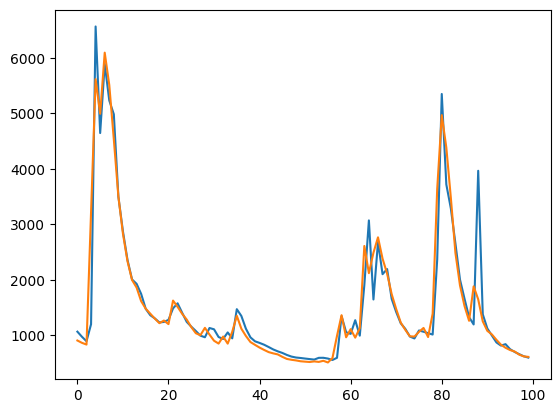

In [129]:
plot_predictions1(model4, X2_test, y2_test)

## LSTM flere lag

In [139]:
model5 = Sequential()
model5.add(InputLayer((6, 5)))
model5.add(LSTM(32, return_sequences=True))
model5.add(LSTM(16))
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 6, 32)             4864      
                                                                 
 lstm_11 (LSTM)              (None, 16)                3136      
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 8145 (31.82 KB)
Trainable params: 8145 (31.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [140]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [141]:
model5.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp5])

Epoch 1/50
172/188 [==========================>...] - ETA: 0s - loss: 5508958.5000 - root_mean_squared_error: 2347.1169INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 5s 18ms/step - loss: 5456378.0000 - root_mean_squared_error: 2335.8892 - val_loss: 5476598.5000 - val_root_mean_squared_error: 2340.2134
Epoch 2/50
178/188 [===========================>..] - ETA: 0s - loss: 5383334.0000 - root_mean_squared_error: 2320.2012INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 5385235.0000 - root_mean_squared_error: 2320.6108 - val_loss: 5394382.5000 - val_root_mean_squared_error: 2322.5811
Epoch 3/50
183/188 [============================>.] - ETA: 0s - loss: 5276043.0000 - root_mean_squared_error: 2296.9639INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 5280337.0000 - root_mean_squared_error: 2297.8984 - val_loss: 5278551.5000 - val_root_mean_squared_error: 2297.5098
Epoch 4/50
180/188 [===========================>..] - ETA: 0s - loss: 5119212.5000 - root_mean_squared_error: 2262.5676INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 5134905.0000 - root_mean_squared_error: 2266.0330 - val_loss: 5119311.0000 - val_root_mean_squared_error: 2262.5894
Epoch 5/50
183/188 [============================>.] - ETA: 0s - loss: 4941219.5000 - root_mean_squared_error: 2222.8855INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 16ms/step - loss: 4954574.5000 - root_mean_squared_error: 2225.8875 - val_loss: 4940600.0000 - val_root_mean_squared_error: 2222.7461
Epoch 6/50
182/188 [============================>.] - ETA: 0s - loss: 4775599.0000 - root_mean_squared_error: 2185.3145INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 4755530.5000 - root_mean_squared_error: 2180.7178 - val_loss: 4746300.0000 - val_root_mean_squared_error: 2178.6006
Epoch 7/50
186/188 [============================>.] - ETA: 0s - loss: 4546279.0000 - root_mean_squared_error: 2132.2004INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 4542521.5000 - root_mean_squared_error: 2131.3191 - val_loss: 4543172.0000 - val_root_mean_squared_error: 2131.4717
Epoch 8/50
180/188 [===========================>..] - ETA: 0s - loss: 4339625.5000 - root_mean_squared_error: 2083.1768INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 15ms/step - loss: 4323672.0000 - root_mean_squared_error: 2079.3442 - val_loss: 4339149.5000 - val_root_mean_squared_error: 2083.0625
Epoch 9/50
183/188 [============================>.] - ETA: 0s - loss: 4120269.0000 - root_mean_squared_error: 2029.8446INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 4105889.7500 - root_mean_squared_error: 2026.2996 - val_loss: 4140162.2500 - val_root_mean_squared_error: 2034.7389
Epoch 10/50
178/188 [===========================>..] - ETA: 0s - loss: 3895208.7500 - root_mean_squared_error: 1973.6283INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 3894979.2500 - root_mean_squared_error: 1973.5702 - val_loss: 3951845.7500 - val_root_mean_squared_error: 1987.9249
Epoch 11/50
185/188 [============================>.] - ETA: 0s - loss: 3713126.5000 - root_mean_squared_error: 1926.9475INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 3696341.2500 - root_mean_squared_error: 1922.5872 - val_loss: 3777560.5000 - val_root_mean_squared_error: 1943.5947
Epoch 12/50
185/188 [============================>.] - ETA: 0s - loss: 3523166.0000 - root_mean_squared_error: 1877.0099INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 15ms/step - loss: 3514697.5000 - root_mean_squared_error: 1874.7527 - val_loss: 3623110.5000 - val_root_mean_squared_error: 1903.4470
Epoch 13/50
185/188 [============================>.] - ETA: 0s - loss: 3323282.7500 - root_mean_squared_error: 1822.9873INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 3331124.2500 - root_mean_squared_error: 1825.1367 - val_loss: 3386856.5000 - val_root_mean_squared_error: 1840.3414
Epoch 14/50
175/188 [==========================>...] - ETA: 0s - loss: 3121184.2500 - root_mean_squared_error: 1766.6874INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 3105836.7500 - root_mean_squared_error: 1762.3384 - val_loss: 3170559.2500 - val_root_mean_squared_error: 1780.6064
Epoch 15/50
184/188 [============================>.] - ETA: 0s - loss: 2930562.5000 - root_mean_squared_error: 1711.8885INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 15ms/step - loss: 2910775.7500 - root_mean_squared_error: 1706.0996 - val_loss: 2975921.7500 - val_root_mean_squared_error: 1725.0861
Epoch 16/50
182/188 [============================>.] - ETA: 0s - loss: 2758266.5000 - root_mean_squared_error: 1660.8030INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 2725928.0000 - root_mean_squared_error: 1651.0385 - val_loss: 2790343.7500 - val_root_mean_squared_error: 1670.4323
Epoch 17/50
184/188 [============================>.] - ETA: 0s - loss: 2519499.5000 - root_mean_squared_error: 1587.2931INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 2551365.0000 - root_mean_squared_error: 1597.2993 - val_loss: 2613702.5000 - val_root_mean_squared_error: 1616.6949
Epoch 18/50
181/188 [===========================>..] - ETA: 0s - loss: 2392570.0000 - root_mean_squared_error: 1546.7935INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 2387485.2500 - root_mean_squared_error: 1545.1489 - val_loss: 2443395.0000 - val_root_mean_squared_error: 1563.1362
Epoch 19/50
184/188 [============================>.] - ETA: 0s - loss: 2244088.2500 - root_mean_squared_error: 1498.0281INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 15ms/step - loss: 2232060.0000 - root_mean_squared_error: 1494.0081 - val_loss: 2282380.2500 - val_root_mean_squared_error: 1510.7549
Epoch 20/50
184/188 [============================>.] - ETA: 0s - loss: 2084816.1250 - root_mean_squared_error: 1443.8893INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 2085930.1250 - root_mean_squared_error: 1444.2749 - val_loss: 2125898.0000 - val_root_mean_squared_error: 1458.0459
Epoch 21/50
185/188 [============================>.] - ETA: 0s - loss: 1958008.2500 - root_mean_squared_error: 1399.2885INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 1947043.0000 - root_mean_squared_error: 1395.3649 - val_loss: 1978440.8750 - val_root_mean_squared_error: 1406.5706
Epoch 22/50
182/188 [============================>.] - ETA: 0s - loss: 1800910.6250 - root_mean_squared_error: 1341.9801INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 15ms/step - loss: 1815730.3750 - root_mean_squared_error: 1347.4904 - val_loss: 1838384.6250 - val_root_mean_squared_error: 1355.8705
Epoch 23/50
179/188 [===========================>..] - ETA: 0s - loss: 1697105.7500 - root_mean_squared_error: 1302.7301INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 1692020.0000 - root_mean_squared_error: 1300.7767 - val_loss: 1703056.7500 - val_root_mean_squared_error: 1305.0122
Epoch 24/50
184/188 [============================>.] - ETA: 0s - loss: 1557480.8750 - root_mean_squared_error: 1247.9907INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 1577570.1250 - root_mean_squared_error: 1256.0135 - val_loss: 1577317.2500 - val_root_mean_squared_error: 1255.9130
Epoch 25/50
188/188 [==============================] - ETA: 0s - loss: 1470283.7500 - root_mean_squared_error: 1212.5526INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 14ms/step - loss: 1470283.7500 - root_mean_squared_error: 1212.5526 - val_loss: 1459706.8750 - val_root_mean_squared_error: 1208.1833
Epoch 26/50
187/188 [============================>.] - ETA: 0s - loss: 1362796.6250 - root_mean_squared_error: 1167.3888INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 17ms/step - loss: 1368485.3750 - root_mean_squared_error: 1169.8228 - val_loss: 1348846.5000 - val_root_mean_squared_error: 1161.3986
Epoch 27/50
188/188 [==============================] - ETA: 0s - loss: 1274633.5000 - root_mean_squared_error: 1128.9967INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 14ms/step - loss: 1274633.5000 - root_mean_squared_error: 1128.9967 - val_loss: 1242119.1250 - val_root_mean_squared_error: 1114.5040
Epoch 28/50
179/188 [===========================>..] - ETA: 0s - loss: 1193090.3750 - root_mean_squared_error: 1092.2867INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 1186560.1250 - root_mean_squared_error: 1089.2935 - val_loss: 1144935.1250 - val_root_mean_squared_error: 1070.0164
Epoch 29/50
178/188 [===========================>..] - ETA: 0s - loss: 1112450.3750 - root_mean_squared_error: 1054.7277INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 1105670.5000 - root_mean_squared_error: 1051.5087 - val_loss: 1056170.0000 - val_root_mean_squared_error: 1027.7013
Epoch 30/50
169/188 [=========================>....] - ETA: 0s - loss: 1032602.2500 - root_mean_squared_error: 1016.1704INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 16ms/step - loss: 1029637.8750 - root_mean_squared_error: 1014.7108 - val_loss: 970571.3125 - val_root_mean_squared_error: 985.1758
Epoch 31/50
169/188 [=========================>....] - ETA: 0s - loss: 965606.1250 - root_mean_squared_error: 982.6526INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 959357.1875 - root_mean_squared_error: 979.4678 - val_loss: 889538.3125 - val_root_mean_squared_error: 943.1534
Epoch 32/50
167/188 [=========================>....] - ETA: 0s - loss: 920291.6250 - root_mean_squared_error: 959.3183INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 895767.4375 - root_mean_squared_error: 946.4499 - val_loss: 817199.1875 - val_root_mean_squared_error: 903.9907
Epoch 33/50
184/188 [============================>.] - ETA: 0s - loss: 836716.3750 - root_mean_squared_error: 914.7220INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 16ms/step - loss: 835936.6250 - root_mean_squared_error: 914.2957 - val_loss: 750368.2500 - val_root_mean_squared_error: 866.2380
Epoch 34/50
176/188 [===========================>..] - ETA: 0s - loss: 787787.3750 - root_mean_squared_error: 887.5739INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 780606.4375 - root_mean_squared_error: 883.5193 - val_loss: 692109.5000 - val_root_mean_squared_error: 831.9312
Epoch 35/50
168/188 [=========================>....] - ETA: 0s - loss: 746177.6875 - root_mean_squared_error: 863.8158INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 729585.1250 - root_mean_squared_error: 854.1575 - val_loss: 632386.7500 - val_root_mean_squared_error: 795.2275
Epoch 36/50
173/188 [==========================>...] - ETA: 0s - loss: 689319.4375 - root_mean_squared_error: 830.2526INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 682481.8125 - root_mean_squared_error: 826.1246 - val_loss: 580841.0000 - val_root_mean_squared_error: 762.1293
Epoch 37/50
177/188 [===========================>..] - ETA: 0s - loss: 636942.9375 - root_mean_squared_error: 798.0870INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 16ms/step - loss: 638981.5625 - root_mean_squared_error: 799.3632 - val_loss: 533887.1875 - val_root_mean_squared_error: 730.6758
Epoch 38/50
174/188 [==========================>...] - ETA: 0s - loss: 611825.7500 - root_mean_squared_error: 782.1929INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 599202.5625 - root_mean_squared_error: 774.0817 - val_loss: 491012.1250 - val_root_mean_squared_error: 700.7226
Epoch 39/50
178/188 [===========================>..] - ETA: 0s - loss: 548438.0000 - root_mean_squared_error: 740.5660INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 562100.5625 - root_mean_squared_error: 749.7336 - val_loss: 453958.9375 - val_root_mean_squared_error: 673.7648
Epoch 40/50
179/188 [===========================>..] - ETA: 0s - loss: 529116.1875 - root_mean_squared_error: 727.4037INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 17ms/step - loss: 528840.5625 - root_mean_squared_error: 727.2142 - val_loss: 413940.6250 - val_root_mean_squared_error: 643.3822
Epoch 41/50
187/188 [============================>.] - ETA: 0s - loss: 493871.9062 - root_mean_squared_error: 702.7602INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 497321.7812 - root_mean_squared_error: 705.2104 - val_loss: 381644.9375 - val_root_mean_squared_error: 617.7742
Epoch 42/50
172/188 [==========================>...] - ETA: 0s - loss: 462295.3125 - root_mean_squared_error: 679.9230INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 467190.9062 - root_mean_squared_error: 683.5137 - val_loss: 354886.2188 - val_root_mean_squared_error: 595.7233
Epoch 43/50
176/188 [===========================>..] - ETA: 0s - loss: 440736.4688 - root_mean_squared_error: 663.8799INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 441233.1562 - root_mean_squared_error: 664.2538 - val_loss: 322426.0625 - val_root_mean_squared_error: 567.8257
Epoch 44/50
167/188 [=========================>....] - ETA: 0s - loss: 409642.2500 - root_mean_squared_error: 640.0330INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 17ms/step - loss: 416481.3125 - root_mean_squared_error: 645.3536 - val_loss: 299474.5938 - val_root_mean_squared_error: 547.2427
Epoch 45/50
184/188 [============================>.] - ETA: 0s - loss: 396819.3125 - root_mean_squared_error: 629.9360INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 14ms/step - loss: 395471.2812 - root_mean_squared_error: 628.8651 - val_loss: 276344.1562 - val_root_mean_squared_error: 525.6844
Epoch 46/50
181/188 [===========================>..] - ETA: 0s - loss: 367702.4688 - root_mean_squared_error: 606.3848INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 374802.5938 - root_mean_squared_error: 612.2112 - val_loss: 254038.7969 - val_root_mean_squared_error: 504.0226
Epoch 47/50
185/188 [============================>.] - ETA: 0s - loss: 359232.1250 - root_mean_squared_error: 599.3597INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 15ms/step - loss: 355886.0625 - root_mean_squared_error: 596.5619 - val_loss: 237333.0469 - val_root_mean_squared_error: 487.1684
Epoch 48/50
174/188 [==========================>...] - ETA: 0s - loss: 340149.0938 - root_mean_squared_error: 583.2230INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 339114.4062 - root_mean_squared_error: 582.3353 - val_loss: 222380.3906 - val_root_mean_squared_error: 471.5723
Epoch 49/50
177/188 [===========================>..] - ETA: 0s - loss: 320765.7500 - root_mean_squared_error: 566.3619INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 322012.5312 - root_mean_squared_error: 567.4615 - val_loss: 202691.7969 - val_root_mean_squared_error: 450.2130
Epoch 50/50
185/188 [============================>.] - ETA: 0s - loss: 307343.5000 - root_mean_squared_error: 554.3857INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 307228.2188 - root_mean_squared_error: 554.2817 - val_loss: 189967.6875 - val_root_mean_squared_error: 435.8528


33/33 [==============================] - 0s 1ms/step


(      Predictions  Actuals
 0     1016.182251   905.19
 1      838.791565   862.98
 2      743.965637   832.00
 3     1058.623901  3217.89
 4     5570.148438  5620.73
 ...           ...      ...
 1024  5025.808594  5197.40
 1025  4368.624023  6368.46
 1026  5585.350098  7162.01
 1027  5594.518555  6869.41
 1028  5556.135742  6335.36
 
 [1029 rows x 2 columns],
 461.3648886646822)

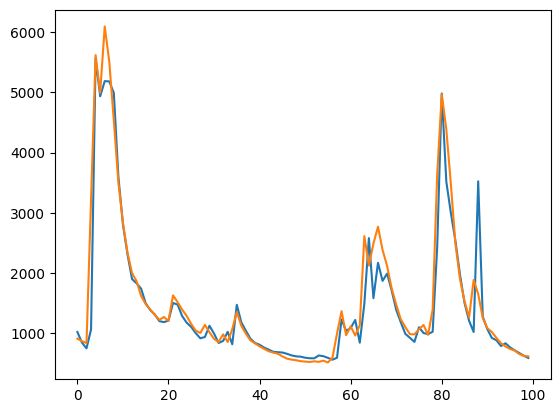

In [142]:
plot_predictions1(model5, X2_test, y2_test)

## Conv1d flere lag

In [143]:
model6 = Sequential()
model6.add(InputLayer((6, 5)))
model6.add(Conv1D(64, kernel_size=2, activation='relu'))
model6.add(Flatten())
model6.add(Dense(8, 'relu'))
model6.add(Dense(1, 'linear'))
model6.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 5, 64)             704       
                                                                 
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dense_24 (Dense)            (None, 8)                 2568      
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3281 (12.82 KB)
Trainable params: 3281 (12.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [144]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [145]:
model6.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp6])

Epoch 1/50
173/188 [==========================>...] - ETA: 0s - loss: 5363540.0000 - root_mean_squared_error: 2315.9319INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 2s 7ms/step - loss: 5360546.0000 - root_mean_squared_error: 2315.2854 - val_loss: 5054811.0000 - val_root_mean_squared_error: 2248.2908
Epoch 2/50
158/188 [========================>.....] - ETA: 0s - loss: 4179055.0000 - root_mean_squared_error: 2044.2737INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 4028038.5000 - root_mean_squared_error: 2006.9974 - val_loss: 2598947.5000 - val_root_mean_squared_error: 1612.1251
Epoch 3/50
141/188 [=====================>........] - ETA: 0s - loss: 2076900.5000 - root_mean_squared_error: 1441.1455INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 1871616.1250 - root_mean_squared_error: 1368.0702 - val_loss: 905718.1250 - val_root_mean_squared_error: 951.6923
Epoch 4/50
146/188 [======================>.......] - ETA: 0s - loss: 1185703.1250 - root_mean_squared_error: 1088.8999INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 1144858.0000 - root_mean_squared_error: 1069.9803 - val_loss: 659502.5625 - val_root_mean_squared_error: 812.0977
Epoch 5/50
136/188 [====================>.........] - ETA: 0s - loss: 983191.4375 - root_mean_squared_error: 991.5601  INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 987056.5000 - root_mean_squared_error: 993.5071 - val_loss: 597729.8750 - val_root_mean_squared_error: 773.1299
Epoch 6/50
145/188 [======================>.......] - ETA: 0s - loss: 921470.6875 - root_mean_squared_error: 959.9326  INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 902721.1875 - root_mean_squared_error: 950.1164 - val_loss: 552317.8750 - val_root_mean_squared_error: 743.1809
Epoch 7/50
104/188 [===============>..............] - ETA: 0s - loss: 859323.9375 - root_mean_squared_error: 926.9973INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 837069.0000 - root_mean_squared_error: 914.9147 - val_loss: 505055.6250 - val_root_mean_squared_error: 710.6727
Epoch 8/50
161/188 [========================>.....] - ETA: 0s - loss: 791746.9375 - root_mean_squared_error: 889.8016INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 776765.1250 - root_mean_squared_error: 881.3428 - val_loss: 465144.6250 - val_root_mean_squared_error: 682.0151
Epoch 9/50
161/188 [========================>.....] - ETA: 0s - loss: 716578.7500 - root_mean_squared_error: 846.5098INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 720857.5000 - root_mean_squared_error: 849.0333 - val_loss: 425508.5000 - val_root_mean_squared_error: 652.3101
Epoch 10/50
133/188 [====================>.........] - ETA: 0s - loss: 649943.0625 - root_mean_squared_error: 806.1905INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 670323.3125 - root_mean_squared_error: 818.7327 - val_loss: 392808.3125 - val_root_mean_squared_error: 626.7442
Epoch 11/50
142/188 [=====================>........] - ETA: 0s - loss: 641271.8750 - root_mean_squared_error: 800.7946INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 625622.4375 - root_mean_squared_error: 790.9630 - val_loss: 362302.5000 - val_root_mean_squared_error: 601.9157
Epoch 12/50
156/188 [=======================>......] - ETA: 0s - loss: 583562.7500 - root_mean_squared_error: 763.9128INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 586765.0000 - root_mean_squared_error: 766.0059 - val_loss: 330907.0938 - val_root_mean_squared_error: 575.2452
Epoch 13/50
163/188 [=========================>....] - ETA: 0s - loss: 545183.3125 - root_mean_squared_error: 738.3653INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 532465.2500 - root_mean_squared_error: 729.7021 - val_loss: 290130.7188 - val_root_mean_squared_error: 538.6378
Epoch 14/50
166/188 [=========================>....] - ETA: 0s - loss: 479805.3438 - root_mean_squared_error: 692.6798INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 484481.1875 - root_mean_squared_error: 696.0468 - val_loss: 262977.1562 - val_root_mean_squared_error: 512.8130
Epoch 15/50
164/188 [=========================>....] - ETA: 0s - loss: 458804.9375 - root_mean_squared_error: 677.3514INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 449716.5625 - root_mean_squared_error: 670.6091 - val_loss: 243622.6719 - val_root_mean_squared_error: 493.5815
Epoch 16/50
164/188 [=========================>....] - ETA: 0s - loss: 430952.7188 - root_mean_squared_error: 656.4699INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 421879.7500 - root_mean_squared_error: 649.5227 - val_loss: 227845.9219 - val_root_mean_squared_error: 477.3321
Epoch 17/50
158/188 [========================>.....] - ETA: 0s - loss: 397714.1875 - root_mean_squared_error: 630.6459INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 400855.4375 - root_mean_squared_error: 633.1315 - val_loss: 214805.5000 - val_root_mean_squared_error: 463.4711
Epoch 18/50
168/188 [=========================>....] - ETA: 0s - loss: 397257.8125 - root_mean_squared_error: 630.2839INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 382431.3750 - root_mean_squared_error: 618.4103 - val_loss: 205903.5781 - val_root_mean_squared_error: 453.7660
Epoch 19/50
166/188 [=========================>....] - ETA: 0s - loss: 366296.9375 - root_mean_squared_error: 605.2247INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 367071.0625 - root_mean_squared_error: 605.8639 - val_loss: 200728.4844 - val_root_mean_squared_error: 448.0273
Epoch 20/50
109/188 [================>.............] - ETA: 0s - loss: 326015.8125 - root_mean_squared_error: 570.9780INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 354102.5625 - root_mean_squared_error: 595.0652 - val_loss: 189983.7031 - val_root_mean_squared_error: 435.8712
Epoch 21/50
147/188 [======================>.......] - ETA: 0s - loss: 334845.4375 - root_mean_squared_error: 578.6583INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 341816.8438 - root_mean_squared_error: 584.6511 - val_loss: 187188.7031 - val_root_mean_squared_error: 432.6531
Epoch 22/50
161/188 [========================>.....] - ETA: 0s - loss: 316970.5625 - root_mean_squared_error: 563.0014INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 332930.5312 - root_mean_squared_error: 577.0013 - val_loss: 179705.0781 - val_root_mean_squared_error: 423.9164
Epoch 23/50
163/188 [=========================>....] - ETA: 0s - loss: 306800.3750 - root_mean_squared_error: 553.8956INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 322730.5312 - root_mean_squared_error: 568.0938 - val_loss: 171493.3750 - val_root_mean_squared_error: 414.1176
Epoch 24/50
164/188 [=========================>....] - ETA: 0s - loss: 316713.0000 - root_mean_squared_error: 562.7726INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 314424.1562 - root_mean_squared_error: 560.7354 - val_loss: 165747.4375 - val_root_mean_squared_error: 407.1209
Epoch 25/50
155/188 [=======================>......] - ETA: 0s - loss: 314755.1562 - root_mean_squared_error: 561.0305INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 306844.6875 - root_mean_squared_error: 553.9356 - val_loss: 162366.4062 - val_root_mean_squared_error: 402.9471
Epoch 26/50
162/188 [========================>.....] - ETA: 0s - loss: 302202.7812 - root_mean_squared_error: 549.7297INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 299563.5938 - root_mean_squared_error: 547.3240 - val_loss: 157485.1094 - val_root_mean_squared_error: 396.8439
Epoch 27/50
188/188 [==============================] - ETA: 0s - loss: 292545.2500 - root_mean_squared_error: 540.8745INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 292545.2500 - root_mean_squared_error: 540.8745 - val_loss: 155637.7500 - val_root_mean_squared_error: 394.5095
Epoch 28/50
166/188 [=========================>....] - ETA: 0s - loss: 284863.6875 - root_mean_squared_error: 533.7263INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 286846.5938 - root_mean_squared_error: 535.5806 - val_loss: 150094.4844 - val_root_mean_squared_error: 387.4203
Epoch 29/50
163/188 [=========================>....] - ETA: 0s - loss: 281773.6875 - root_mean_squared_error: 530.8236INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 281036.1562 - root_mean_squared_error: 530.1284 - val_loss: 146936.8281 - val_root_mean_squared_error: 383.3234
Epoch 30/50
158/188 [========================>.....] - ETA: 0s - loss: 269364.5938 - root_mean_squared_error: 519.0035INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 275883.8750 - root_mean_squared_error: 525.2465 - val_loss: 143333.0625 - val_root_mean_squared_error: 378.5935
Epoch 31/50
166/188 [=========================>....] - ETA: 0s - loss: 275649.8438 - root_mean_squared_error: 525.0237INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 270294.9688 - root_mean_squared_error: 519.8990 - val_loss: 141024.7031 - val_root_mean_squared_error: 375.5326
Epoch 32/50
167/188 [=========================>....] - ETA: 0s - loss: 266068.9688 - root_mean_squared_error: 515.8187INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 1s 4ms/step - loss: 266620.4062 - root_mean_squared_error: 516.3530 - val_loss: 138094.5781 - val_root_mean_squared_error: 371.6108
Epoch 33/50
167/188 [=========================>....] - ETA: 0s - loss: 274271.6875 - root_mean_squared_error: 523.7095INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 262129.3438 - root_mean_squared_error: 511.9857 - val_loss: 136558.2188 - val_root_mean_squared_error: 369.5378
Epoch 34/50
108/188 [================>.............] - ETA: 0s - loss: 262605.3438 - root_mean_squared_error: 512.4503INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 258349.3125 - root_mean_squared_error: 508.2807 - val_loss: 134453.2812 - val_root_mean_squared_error: 366.6787
Epoch 35/50
167/188 [=========================>....] - ETA: 0s - loss: 254110.4375 - root_mean_squared_error: 504.0937INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 254696.5469 - root_mean_squared_error: 504.6747 - val_loss: 130510.3438 - val_root_mean_squared_error: 361.2621
Epoch 36/50
164/188 [=========================>....] - ETA: 0s - loss: 247865.4375 - root_mean_squared_error: 497.8609INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 251081.9688 - root_mean_squared_error: 501.0808 - val_loss: 127882.4766 - val_root_mean_squared_error: 357.6066
Epoch 37/50
163/188 [=========================>....] - ETA: 0s - loss: 254750.8281 - root_mean_squared_error: 504.7285INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 248062.3438 - root_mean_squared_error: 498.0586 - val_loss: 124939.2578 - val_root_mean_squared_error: 353.4675
Epoch 38/50
188/188 [==============================] - 0s 781us/step - loss: 244304.5938 - root_mean_squared_error: 494.2718 - val_loss: 125517.7891 - val_root_mean_squared_error: 354.2849
Epoch 39/50
116/188 [=================>............] - ETA: 0s - loss: 246280.5312 - root_mean_squared_error: 496.2666INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 242064.5781 - root_mean_squared_error: 492.0006 - val_loss: 121376.9531 - val_root_mean_squared_error: 348.3920
Epoch 40/50
168/188 [=========================>....] - ETA: 0s - loss: 234758.0781 - root_mean_squared_error: 484.5184INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 240038.2656 - root_mean_squared_error: 489.9370 - val_loss: 120886.2578 - val_root_mean_squared_error: 347.6870
Epoch 41/50
157/188 [========================>.....] - ETA: 0s - loss: 245184.9375 - root_mean_squared_error: 495.1615INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 237522.5000 - root_mean_squared_error: 487.3628 - val_loss: 119220.3828 - val_root_mean_squared_error: 345.2831
Epoch 42/50
188/188 [==============================] - 0s 759us/step - loss: 235085.7969 - root_mean_squared_error: 484.8565 - val_loss: 119818.7969 - val_root_mean_squared_error: 346.1485
Epoch 43/50
168/188 [=========================>....] - ETA: 0s - loss: 236755.4688 - root_mean_squared_error: 486.5753INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 232785.3281 - root_mean_squared_error: 482.4783 - val_loss: 117596.3672 - val_root_mean_squared_error: 342.9233
Epoch 44/50
161/188 [========================>.....] - ETA: 0s - loss: 225385.9688 - root_mean_squared_error: 474.7483INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 231084.4844 - root_mean_squared_error: 480.7125 - val_loss: 114894.0547 - val_root_mean_squared_error: 338.9603
Epoch 45/50
188/188 [==============================] - 0s 742us/step - loss: 228972.6875 - root_mean_squared_error: 478.5109 - val_loss: 115516.5547 - val_root_mean_squared_error: 339.8773
Epoch 46/50
177/188 [===========================>..] - ETA: 0s - loss: 230292.5938 - root_mean_squared_error: 479.8881INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 227264.5312 - root_mean_squared_error: 476.7227 - val_loss: 113113.7344 - val_root_mean_squared_error: 336.3239
Epoch 47/50
110/188 [================>.............] - ETA: 0s - loss: 185491.3750 - root_mean_squared_error: 430.6871INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 225526.0938 - root_mean_squared_error: 474.8959 - val_loss: 111364.8203 - val_root_mean_squared_error: 333.7137
Epoch 48/50
188/188 [==============================] - 0s 729us/step - loss: 224002.7344 - root_mean_squared_error: 473.2893 - val_loss: 112682.2031 - val_root_mean_squared_error: 335.6817
Epoch 49/50
168/188 [=========================>....] - ETA: 0s - loss: 218864.6406 - root_mean_squared_error: 467.8297INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 222542.5938 - root_mean_squared_error: 471.7442 - val_loss: 111153.5156 - val_root_mean_squared_error: 333.3969
Epoch 50/50
162/188 [========================>.....] - ETA: 0s - loss: 223710.8438 - root_mean_squared_error: 472.9808INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 221038.1719 - root_mean_squared_error: 470.1470 - val_loss: 108257.4844 - val_root_mean_squared_error: 329.0251


33/33 [==============================] - 0s 455us/step


(      Predictions  Actuals
 0     1117.211426   905.19
 1      885.519043   862.98
 2     1000.032288   832.00
 3     1589.037231  3217.89
 4     5044.663574  5620.73
 ...           ...      ...
 1024  4896.996582  5197.40
 1025  4568.659180  6368.46
 1026  5620.503418  7162.01
 1027  6403.982910  6869.41
 1028  6061.854004  6335.36
 
 [1029 rows x 2 columns],
 400.44771657802914)

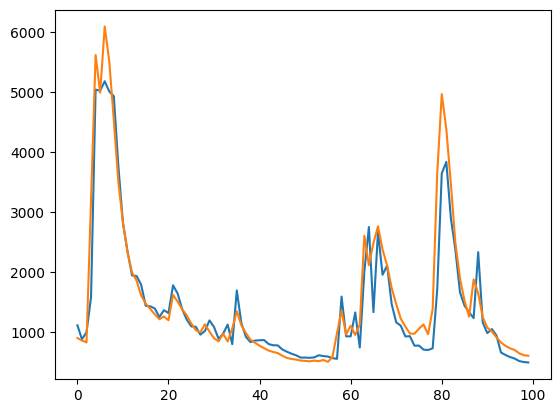

In [146]:
plot_predictions1(model6, X2_test, y2_test)